<a href="https://colab.research.google.com/github/zia207/r-colab/blob/main/NoteBook/Remote%20Sensing/training_data_processing_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Data Processing for Landuse Classification

In this lesson, we will use a sub-set of Landsat 9 satellite megapixel-based in the central part of the country.  We will prepare them for pixel-based classification using machine learning algorithms. The images were already radiometrically and atmospherically corrected.

We will train the machine learning models with four feature classes extracted from Google Earth imagery: (1) Home stage vegetation, (2) cropland, (3) Bare soil/Developed, and (4) water bodies. We used on-screen digitization in ArcMap to Create polygons representing members of these feature classes. First, we will convert the polygons to a 30 x 30-meter raster grid and then to a spatial points data frame. Next, we will extract values from the B2, B3, B4, B5, B6, and B7 bands and 30 m SRTM DEM and add them to the spatial point data frame we will use for training, validation, and testing the models. We will also use all these bands and DEM to create a prediction grid point data set for predicting land-use classes.

### Install rpy2

In [1]:

!pip uninstall rpy2 -y
!pip install rpy2==3.5.1
%load_ext rpy2.ipython

Found existing installation: rpy2 3.4.2
Uninstalling rpy2-3.4.2:
  Successfully uninstalled rpy2-3.4.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.7/201.7 kB 3.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for rpy2: filename=rpy2-3.5.1-cp310-cp310-linux_x86_64.whl size=314927 sha256=5439b56ab8c7fc8df4d6615ec97804976a9061253e88a49a14802cb36568ea87
  Stored in directory: /root/.cache/pip/wheels/73/a6/ff/4e75dd1ce1cfa2b9a670cbccf6a1e41c553199e9b25f05d953
Successfully built rpy2


### Mount Google Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Install Required R Package

In [ ]:
%%R
pkg <- c('tidyverse', 'raster', 'rgdal','terra','tidyterra', 'maptools', 'sf', 'classInt',
         'RColorBrewer', 'tmap','tmaptools', 'gridExtra', 'devtools')
new.packages <- pkg[!(pkg %in% installed.packages(lib='drive/My Drive/R/')[,"Package"])]
if(length(new.packages)) install.packages(new.packages, lib='drive/My Drive/R/')

In [ ]:
%%R
remotes::install_github("rstudio/tensorflow", lib='drive/My Drive/R/')

In [ ]:
%%R
install.packages("keras",lib='drive/My Drive/R/' )

### Install R-packages

In [3]:
%%R
.libPaths('drive/My Drive/R')
library (terra)
library (tidyterra)
library(sf)
library(raster)
library(rgdal)
library(tidyverse)
library(RColorBrewer)
library(RStoolbox)
library(gridExtra)


Attaching package: ‘tidyterra’



    filter




which was just loaded, will retire in October 2023.
Please refer to R-spatial evolution reports for details, especially
https://r-spatial.org/r/2023/05/15/evolution4.html.
It may be desirable to make the sf package available;
package maintainers should consider adding sf to Suggests:.
The sp package is now running under evolution status 2
     (status 2 uses the sf package in place of rgdal)

Attaching package: ‘raster’



    select


plan transition to sf/stars/terra functions using GDAL and PROJ
at your earliest convenience.
See https://r-spatial.org/r/2023/05/15/evolution4.html and https://github.com/r-spatial/evolution
rgdal: version: 1.6-7, (SVN revision 1203)
Geospatial Data Abstraction Library extensions to R successfully loaded
Loaded GDAL runtime: GDAL 3.4.3, released 2022/04/22
Path to GDAL shared files: /usr/share/gdal
GDAL binary built with GEOS: TRUE 
Loaded PROJ runtime: Rel. 8.2.1, January 1st, 2022, [PJ_VERSION: 821]
Pa

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.3     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ tidyr::extract() masks raster::extract(), terra::extract()
✖ dplyr::filter()  masks tidyterra::filter(), stats::filter()
✖ dplyr::lag()     masks stats::lag()
✖ dplyr::select()  masks raster::select(), tidyterra::select()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


Attaching package: ‘gridExtra’



    combine




### Data

In [ ]:
%%R
bd<-st_read("/content/drive/MyDrive/Data/DSM_AOI/AOI_BD/aoi_dsm_UTM46N.shp")
aoi<-st_read("/content/drive/MyDrive/Data/DSM_AOI/AOI_BD/aoi_dsm_UTM46N.shp")
aoi_01<-st_read("/content/drive/MyDrive/Data/DSM_AOI/Image_Classification_Landsat9/Landsat_Subset/AOI_1/AOI_1.shp")
ls<-rast("/content/drive/MyDrive/Data/DSM_AOI/Landsat/Level_01/Scene/LC08_L1TP_137044_20230203_20230209_02_T1/LC08_L1TP_137044_20230203_20230209_02_T1_B1.TIF")

Reading layer `aoi_dsm_UTM46N' from data source 
  `/content/drive/MyDrive/Data/DSM_AOI/AOI_BD/aoi_dsm_UTM46N.shp' 
  using driver `ESRI Shapefile'
Simple feature collection with 0 features and 1 field
Bounding box:  xmin: NA ymin: NA xmax: NA ymax: NA
Projected CRS: WGS 84 / UTM zone 46N + unknown
Reading layer `aoi_dsm_UTM46N' from data source 
  `/content/drive/MyDrive/Data/DSM_AOI/AOI_BD/aoi_dsm_UTM46N.shp' 
  using driver `ESRI Shapefile'
Simple feature collection with 0 features and 1 field
Bounding box:  xmin: NA ymin: NA xmax: NA ymax: NA
Projected CRS: WGS 84 / UTM zone 46N + unknown
Reading layer `AOI_1' from data source 
  `/content/drive/MyDrive/Data/DSM_AOI/Image_Classification_Landsat9/Landsat_Subset/AOI_1/AOI_1.shp' 
  using driver `ESRI Shapefile'
Simple feature collection with 1 feature and 6 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: 150901.7 ymin: 2558579 xmax: 180901.7 ymax: 2588579
Projected CRS: WGS 84 / UTM zone 46N + unknown


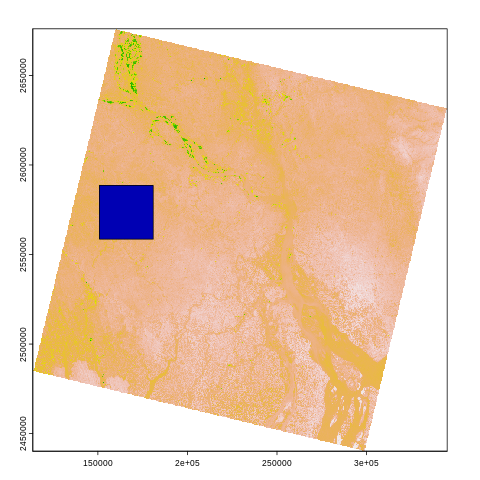

In [ ]:
%%R -w 400 -h 400 -u px
#plot(bd, main= "Landsat 8 Scene: 137/44 and AOI")
plot(ls, legend =F)
plot(aoi_01, add=TRUE)

### Import Raster Images

In [8]:
%%R
# AOI-1
multi_01<-raster::stack("/content/drive/MyDrive/Data/DSM_AOI/Image_Classification_Landsat9/Landsat_Subset/AOI_1/multiband_2_7_aoi_1.tif")
dem_01<-raster::raster('/content/drive/MyDrive/Data/DSM_AOI/Image_Classification_Landsat9/Landsat_Subset/AOI_1/dem_aoi_1.tif')
names(dem_01)<-"dem"

In [6]:
%%R
# AOI-2
multi_02<-raster::stack("/content/drive/MyDrive/Data/DSM_AOI/Image_Classification_Landsat9/Landsat_Subset/AOI_2/multiband_2_7_aoi_2.tif")
dem_02<-raster::raster('/content/drive/MyDrive/Data/DSM_AOI/Image_Classification_Landsat9/Landsat_Subset/AOI_2/dem_aoi_2.tif')
names(dem_02)<-"dem"

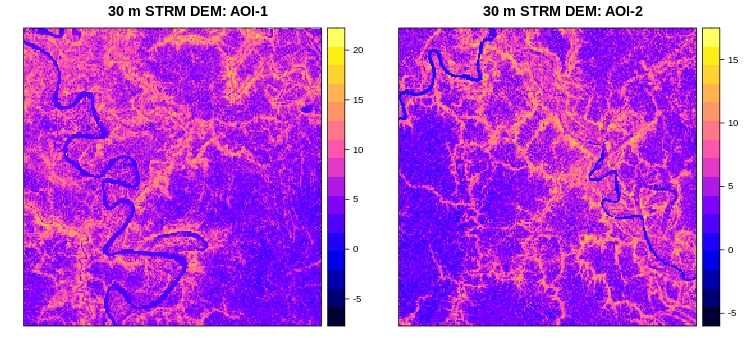

In [44]:
%%R -w 750 -h 350 -u px
p1 = spplot(dem_01, main="30 m STRM DEM: AOI-1")
p2 = spplot(dem_02, main="30 m STRM DEM: AOI-2")
grid.arrange(p1, p2, ncol=2)

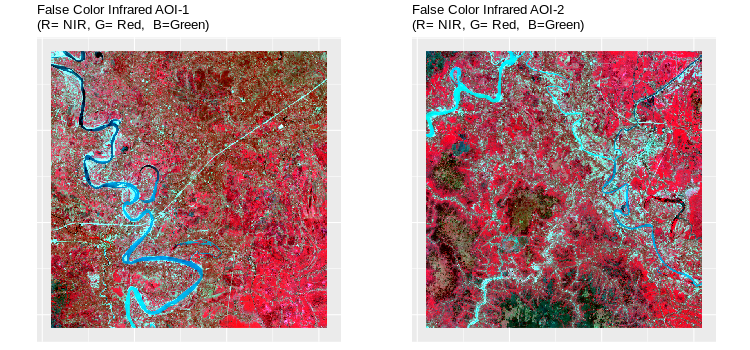

In [46]:
%%R -w 750 -h 350 -u px
# False Color image
p3=ggRGB(multi_01, r=4, g=3, b=2, stretch = "lin")+
  theme(axis.title.x=element_blank(),
        axis.text.x=element_blank(),
        axis.ticks.x=element_blank(),
        axis.title.y=element_blank(),
        axis.text.y=element_blank(),
        axis.ticks.y=element_blank())+
  ggtitle("False Color Infrared AOI-1\n(R= NIR, G= Red,  B=Green)")

p4=ggRGB(multi_02, r=4, g=3, b=2, stretch = "lin")+
  theme(axis.title.x=element_blank(),
        axis.text.x=element_blank(),
        axis.ticks.x=element_blank(),
        axis.title.y=element_blank(),
        axis.text.y=element_blank(),
        axis.ticks.y=element_blank())+
  ggtitle("False Color Infrared AOI-2\n(R= NIR, G= Red,  B=Green)")

grid.arrange(p3, p4, ncol=2)

## Training Data Processing

### Convert training polygon to raster

Before converting the land use polygon file to raster, we will extract the extent of any band of Landsat 9 to set the raster extent. We use B2 to define raster extent.

In [13]:
%%R
poly <- st_read('/content/drive/MyDrive/Data/DSM_AOI/Image_Classification_Landsat9/Landsat_Subset/AOI_1/train_poly_aoi_1.shp')
poly

Reading layer `train_poly_aoi_1' from data source 
  `/content/drive/MyDrive/Data/DSM_AOI/Image_Classification_Landsat9/Landsat_Subset/AOI_1/train_poly_aoi_1.shp' 
  using driver `ESRI Shapefile'
replacing null geometries with empty geometries
Simple feature collection with 154 features and 1 field (with 2 geometries empty)
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: 151135 ymin: 2558741 xmax: 180431.2 ymax: 2588311
Projected CRS: WGS 84 / UTM zone 46N + unknown
Simple feature collection with 154 features and 1 field (with 2 geometries empty)
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: 151135 ymin: 2558741 xmax: 180431.2 ymax: 2588311
Projected CRS: WGS 84 / UTM zone 46N + unknown
First 10 features:
   Id                       geometry
1   0 POLYGON ((167583.4 2575164,...
2   0 POLYGON ((165182.3 2573127,...
3   0 POLYGON ((164196.7 2575210,...
4   0 POLYGON ((162682 2571758, 1...
5   0 POLYGON ((160896.9 2584646,...
6   0 POLYGON ((161885.7 2584652,

In [18]:
%%R
extent<-ext(multi_01[[2]])


In [19]:
%%R
# create an empty raster
r <- rast(extent, resolution = 10)
rp <- rasterize(poly, r, 'Id')


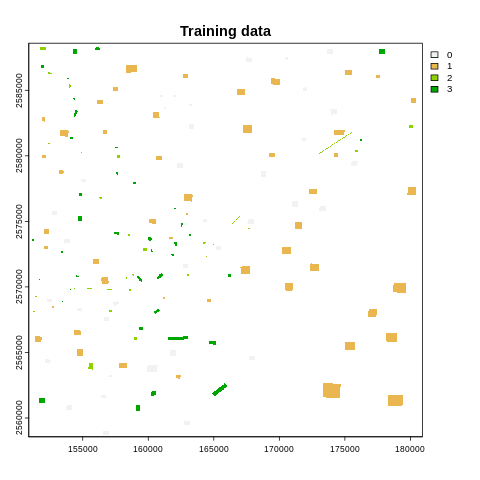

In [ ]:
%%R
plot(rp, main="Training data")

### Convert to Spatial Point dataframe

In [20]:
%%R
rp.df <- as.data.frame(rp, xy = TRUE)

In [21]:
%%R
levels(as.factor(rp.df$Id))

[1] "0" "1" "2" "3"


In [22]:
%%R
xy <- rp.df[,c(1,2)]
point.SPDF<- SpatialPointsDataFrame(coords = xy,
                                data=rp.df,
                                proj4string = CRS("+proj=utm +zone=46 +datum=WGS84 +units=m +no_defs +type=crs"))

### Extract bands  and dem values to training points

In [23]:
%%R
point.bands <- raster::extract(multi_01, point.SPDF)
point.dem <- raster::extract(dem_01, point.SPDF)
point.mf<-cbind(rp.df,point.bands, point.dem)
colnames(point.mf)[10]<-"dem"
glimpse(point.mf)

Rows: 215,854
Columns: 10
$ x   <dbl> 152170, 152180, 152000, 152010, 152020, 152030, 152040, 152050, 15…
$ y   <dbl> 2588310, 2588310, 2588300, 2588300, 2588300, 2588300, 2588300, 258…
$ Id  <int> 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, …
$ B2  <dbl> 12573, 12554, 12559, 12559, 12559, 12577, 12577, 12577, 12605, 126…
$ B3  <dbl> 14378, 14299, 14336, 14336, 14336, 14338, 14338, 14338, 14333, 143…
$ B4  <dbl> 15320, 15181, 15347, 15347, 15347, 15272, 15272, 15272, 15257, 152…
$ B5  <dbl> 18372, 18142, 18525, 18525, 18525, 18304, 18304, 18304, 18288, 182…
$ B6  <dbl> 21751, 21507, 21824, 21824, 21824, 21778, 21778, 21778, 21682, 216…
$ B7  <dbl> 21393, 21176, 21448, 21448, 21448, 21467, 21467, 21467, 21421, 214…
$ dem <dbl> 5.126486, 5.851623, 5.102431, 4.999510, 4.999510, 4.999510, 5.0063…


In [ ]:
%%R
levels(as.factor(point.mf$Id))
write_csv(point.mf, "/content/drive/MyDrive/Data/DSM_AOI/Image_Classification_Landsat9/Landsat_Subset/AOI_1/point_data.csv")

### Add class ID and save as a CSV file

In [25]:
%%R
# Import lnaduse ID file
ID<-read.csv("/content/drive/MyDrive/Data/DSM_AOI/Image_Classification_Landsat9/Landsat_Subset/AOI_1/landuse_id.csv")
ID

  Id   Class           Description
1  0 Class_1 Homestead vegetation 
2  1 Class_2              Cropland
3  2 Class_3   Bare soil/Developed
4  3 Class_4            Water body


In [26]:
%%R
# Join with point data frame
point.gt<-merge(point.mf, ID, by="Id", type="inner")
head(point.gt)
write_csv(point.gt, "/content/drive/MyDrive/Data/DSM_AOI/Image_Classification_Landsat9/Landsat_Subset/AOI_1/point_data.csv")

## Grid Data Processing

First, we will empty point data frame, will use Band B2

In [27]:
%%R
multi_01

class      : RasterStack 
dimensions : 1001, 1001, 1002001, 6  (nrow, ncol, ncell, nlayers)
resolution : 30, 30  (x, y)
extent     : 150885, 180915, 2558565, 2588595  (xmin, xmax, ymin, ymax)
crs        : +proj=utm +zone=46 +datum=WGS84 +units=m +no_defs 
names      :    B2,    B3,    B4,    B5,    B6,    B7 
min values :  7418,  8493,  7597,  8822,  7904,  7622 
max values : 14226, 16173, 17473, 24870, 26354, 24278 



In [29]:
%%R
grid.point_01 <- data.frame(rasterToPoints(multi_01[[1]]))
# Remove B2 column, just keep x & y
grid.point_01$B2<-NULL
# define co-ordinates and projection
coordinates(grid.point_01) <- ~x + y
projection(grid.point_01) <- CRS("+proj=utm +zone=46 +datum=WGS84 +units=m +no_defs +type=crs")

In [30]:
%%R
grid.point_02 <- data.frame(rasterToPoints(multi_02[[1]]))
# Remove B2 column, just keep x & y
grid.point_02$B2<-NULL
# define co-ordinates and projection
coordinates(grid.point_02) <- ~x + y
projection(grid.point_02) <- CRS("+proj=utm +zone=46 +datum=WGS84 +units=m +no_defs +type=crs")

### Extract all bands and dem values to grird locations

In [ ]:
%%R
bands.grid_01<- raster::extract(multi_01, grid.point_01, df=TRUE, method='simple')
dem.grid_01<- raster::extract(dem_01, grid.point_01, df=TRUE, method='simple')
grid_01<-cbind(as.data.frame(grid.point_01),bands.grid_01, dem.grid_01)
grid_01[,10]<-NULL
write_csv(grid_01,"/content/drive/MyDrive/Data/DSM_AOI/Image_Classification_Landsat9/Landsat_Subset/AOI_1/prediction_grid_data_01.csv" )
head(grid_01)

In [33]:
%%R
bands.grid_02<- raster::extract(multi_02, grid.point_02, df=TRUE, method='simple')
dem.grid_02<- raster::extract(dem_02, grid.point_02, df=TRUE, method='simple')
grid_02<-cbind(as.data.frame(grid.point_02),bands.grid_02, dem.grid_02)
grid_02[,10]<-NULL
write_csv(grid_02,"/content/drive/MyDrive/Data/DSM_AOI/Image_Classification_Landsat9/Landsat_Subset/AOI_1/prediction_grid_data_02.csv" )
head(grid_02)

       x       y ID   B2    B3   B4    B5   B6   B7      dem
1 150930 2558550  1 8459 10037 9552 10785 8723 8083 4.824776
2 150960 2558550  2 8440  9984 9508 10670 8742 8139 5.421584
3 150990 2558550  3 8405  9943 9478 10395 8476 7983 4.683115
4 151020 2558550  4 8453  9972 9517 11683 9858 8874 4.545923
5 151050 2558550  5 8461 10052 9515 11521 9530 8642 5.788843
6 151080 2558550  6 8424 10075 9507 10427 8649 8078 6.390258


### Further Reading

1.  [R - using Random Forests, Support Vector Machines, and Neural Networks for a pixel-based supervised classification of Sentinel-2 multispectral images](https://valentinitnelav.github.io/satellite-image-classification-r/)